In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import ipaddress as ip
import tldextract
import pickle as pkl
import sklearn.ensemble as ensembleLearning
import sklearn
import re
import unicodedata

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn import linear_model
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from urllib.parse import urlparse, urlsplit
from urllib.parse import parse_qs
from posixpath import basename, dirname
from __future__ import division
from scipy import stats
from sklearn_pandas import DataFrameMapper

In [2]:
# Original Dataset with Domain + Label with other features value
data = pd.read_csv('DataSet/PhishLegitimateDataSet.csv')
# data.head()
# Get domain and label only : 1st way
header = ['domain', 'label']
# Export to new CSV
data.to_csv('DataSet/PhishLegitimateDataSet_Cleaned1.csv', columns = header, index = False)

# Get domain and label only : 2nd way
dfRequired = data[['domain', 'label']]
# Export to new CSV
dfRequired.to_csv('DataSet/PhishLegitimateDataSet_Cleaned2.csv', index = False)
dfRequired.head()

,domain,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1.0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1.0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1.0
3,mail.printakid.com/www.online.americanexpress....,1.0
4,thewhiskeydregs.com/wp-content/themes/widescre...,1.0


In [3]:
# Helper Functions
def get_f1_score(Y_test, Y_predict, title):
    test_size = len(Y_test)
    score = 0
    
    for i in range(test_size):
        if Y_predict[i] == Y_test[i]:
            score += 1
            
    print('Got %s out of %s' % (score, test_size))
    print('f1 = %.2f' % (f1_score(Y_test, Y_predict, average = 'binary')))
    print('precision = %.2f' % (precision_score(Y_test, Y_predict, average = 'binary')))
    print('recall = %.2f' % (recall_score(Y_test, Y_predict, average = 'binary')))
    print('accuracy = %.2f' % (accuracy_score(Y_test, Y_predict)))

    bar_width = 0.20
    opacity = 0.4
    error_config = {'ecolor': '0.3'}
    index = np.arange(1)

    fig, ax = plt.subplots()

    ax.bar(index, f1_score(Y_test, Y_predict, average = 'binary'), bar_width,
           alpha = opacity, color = 'b',
           error_kw = error_config,
           label = 'F Score')
    ax.bar(index + bar_width * 1, precision_score(Y_test, Y_predict, average = 'binary'), bar_width,
           alpha = opacity, color = 'r',
           error_kw = error_config,
           label = 'Precision')
    ax.bar(index + bar_width * 2, recall_score(Y_test, Y_predict, average = 'binary'), bar_width,
           alpha = opacity, color = 'g',
           error_kw = error_config,
           label = 'Recall')
    ax.bar(index + bar_width * 3, accuracy_score(Y_test, Y_predict), bar_width,
           alpha = opacity, color = 'y',
           error_kw = error_config,
           label = 'Accuracy')
    ax.set_xlabel('Measures')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.tick_params(
        axis = 'x',           # changes apply to the x-axis
        which = 'both',       # both major and minor ticks are affected
        bottom = False,       # ticks along the bottom edge are off
        top = False,          # ticks along the top edge are off
        labelbottom = False)  # labels along the bottom edge are off
    ax.legend()
    fig.tight_layout()
    plt.show()
    
def show_scores_bar(results, models):
    bar_width = 0.20
    opacity = 0.4
    error_config = {'ecolor': '0.3'}
    index = np.arange(1)

    fig, ax = plt.subplots()
    
    bar_colors = ['b', 'r', 'g', 'y', 'c', 'm', 'k']
    i = 0
    
    for algo in models:
        ax.bar(index + bar_width * i, results[algo], bar_width, alpha = opacity, 
               color = bar_colors[i], error_kw = error_config, label = algo)
        i += 1
    
    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_title('Score of different Classifiers')
    ax.tick_params(
        axis = 'x',           # changes apply to the x-axis
        which = 'both',       # both major and minor ticks are affected
        bottom = False,       # ticks along the bottom edge are off
        top = False,          # ticks along the top edge are off
        labelbottom = False)  # labels along the bottom edge are off
    ax.legend()
    fig.tight_layout()
    plt.show()
    
# we use this function when feature vector has label (binary) at end, 
# and use it in conjuction with def make_np_array_XY(xy):
def make_feature_vector(from_index, url, label):
    feature_vector = []
    for i in range(len(url)):
        s = url[from_index + i]
        if len(s) > 0:
            feature = getFeatures(url[from_index + i], label[from_index + i])
        feature_vector.append(feature)
    return feature_vector

def make_np_array_XY(xy):
    a = np.array(xy)
    x = a[:, 0:-1]
    y = a[:, -1]
    return x, y

def get_length(str):
    return len(str)

def get_forward_slash_count(str):
    return str.count('/')

def get_dot_count(str):
    return str.count('.')

def getTokens(input):
    tokensBySlash = str(input.encode('utf-8')).split('/')
    allTokens = []
    
    for i in tokensBySlash:
        tokens = str(i).split('-')
        tokensByDot = []
        for j in range(0,len(tokens)):
            tempTokens = str(tokens[j]).split('.')
            tokensByDot = tokensByDot + tempTokens
        allTokens = allTokens + tokens + tokensByDot
        
    allTokens = list(set(allTokens))
    
    if 'com' in allTokens:
        allTokens.remove('com')
        
    return allTokens

def get_url_scheme(url):
    parse_object = urlparse(url)
    return parse_object.scheme

def get_domain_from_url(url):
    return url[:url.find('/',8)]

def get_path_from_url(url):
    return url[url.find('/',8):]

def getTokens1(url):
    return re.split('\W+', url)

def sub_directory(url):
    path = urlparse(url).path
    dirname_path = dirname(urlparse(url).path)
    path = path.replace(dirname_path, '')
    return path

def hostname(url):
    p = '(?:http.*://)?(?P<host>[^:/ ]+).?(?P<port>[0-9]*).*'
    m = re.search(p, url)
    return m.group('host')

delim = ['-',
         '.',
         '_',
         '~',
         ':',
         '/',
         '?',
         '#',
         '[',
         ']',
         '@',
         '!',
         '$',
         '&',
         '\'',
         '(',
         ')',
         '*',
         '+',
         ',',
         ';',
         '=',
         '`',
         '.']

file = open('blacklists.txt', 'r', encoding = 'utf-8')
black_list = file.read().split()
for word in black_list:
    if type(word) != str:
        try:
            word = str(word)
        except:
            print(word)

In [4]:
def has_blacklist_word(url):
    for word in black_list:
        if word in url:
            return 1
    return 0

def is_hostname_unicode(url):
    host_name = hostname(url)
    
    if isinstance(host_name, str):
        return 1
    
    for s in host_name:
        if isinstance(s, str):
            return 1
        
    return 0

def isip(uri):
    try:
        if ip.ip_address(uri):
            return 1
    except:
        return 0
    
def count_queries(query):
    if not query:
        return 0
    else:
        return len(query.split('&'))

def scheme_http_or_not(url):
    if get_url_scheme(url) == 'http' or get_url_scheme(url) == 'https':
        return 1
    
    return 0

def is_https(url):
    if get_url_scheme(url) == 'http' or get_url_scheme(url) == 'https':
        if get_url_scheme(url) == 'https':
            return 1
        else:
            return 0
    else:
        return 0
    
def is_exe(url):
    if ".exe" in url:
        return 1 
    else:
        return 0 
    
def is_short_url(url):
    if ".ly" in url:
        return 1
    else:
        return 0
    
def suspicious_word_count(url):
    tokens_words = getTokens1(url)
    sec_sen_words = ['confirm',
                     'signon',
                     'account',
                     'password',
                     'pwd',
                     'saving',
                     'checking',
                     'banking',
                     'secure',
                     'ebayisapi',
                     'webscr',
                     'login',
                     'signin',
                     'recovery',
                     'forgotpassword']
    cnt = 0
    
    for ele in sec_sen_words:
        if(ele in tokens_words):
            cnt += 1
            
    return cnt

def Has_IP(url):
    tokens_words = getTokens1(url)
    cnt = 0

    for ele in tokens_words:
        try:
            ele = unicode(ele, "utf-8")
            ip = ipaddress.ip_address(ele)
            cnt += 1
        except:
            pass
    
    if cnt > 0:
        return 1
    
    return 0

def token_count(url):
    return len(getTokens1(url))

def has_port_number(url):
    url_port = urlparse(url)
    
    if url_port.port != None:
        return 1
    
    return 0

def filename_length(url):
    return len(basename(urlparse(url).path).split('.')[0])

# LEXICAL FEATURES
# URL Related
def domain_token_count(url):
    return len(getTokens1(tldextract.extract(url).domain))

def query_variables_count(url):
    return len(parse_qs(urlparse(url).query, keep_blank_values = True))

def max_length_of_query_variables(url):
    queries = (parse_qs(urlparse(url).query, keep_blank_values = True))
    if queries.keys():
        try:
            return max(len(query_key) for query_key in queries.keys() if query_key)
        except:
            return 0
    return 0

def key_value_pairs_count(url):
    return len(dict(parse_qs(urlsplit(url).query)).keys())

def special_chars_count(url):
    count = 0
    for url_char in url:
        if not url_char.isalnum():
                count = count + 1
    return count

def alphabet_count(url):
    return sum(url_char.isalpha() for url_char in url)

def digit_count(url):
    return sum(url_char.isdigit() for url_char in url)

def get_at_count(str):
    return str.count('@')
    
def get_hyphen_count(str):
    return str.count('-')

def get_amp_count(str):
    return str.count('&')

def get_delimeter_count(str):
    count = 0
    for each in str:
        if each in delim:
            count = count + 1
    return count

def get_forward_slash_count_in_url(url):
    return get_forward_slash_count(url)

def get_dot_count_in_url(url):
    return get_dot_count(url)

def get_url_length(url):
    return get_length(url)

# Domain Related
def countSubDomain(subdomain):
    if not subdomain:
        return 0
    else:
        return len(subdomain.split('.'))

def subdomain_length(url):
    return len(tldextract.extract(url).subdomain)

def get_forward_slash_count_in_domain(url):
    return get_forward_slash_count(get_domain_from_url(url))

def get_dot_count_in_domain(url):
    return get_dot_count(get_domain_from_url(url))

def get_domain_length(url):
    return get_length(get_domain_from_url(url))

# Path Related
def directory_name_length(url):
    return len(dirname(urlparse(url).path))

def get_forward_slash_count_in_path(url):
    return get_forward_slash_count(get_path_from_url(url))

def get_dot_count_in_path(url):
    return get_dot_count(get_path_from_url(url))

def get_path_length(url):
    return get_length(get_path_from_url(url))

def longest_token_path(url):
    tokens = getTokens1(urlparse(url).path)
    return max(len(token) for token in tokens)

def sub_directory_tokens_count(url):
    path = sub_directory(url)
    tokens = re.split('\W+', path)
    tokens = filter(None, tokens)
    return len(list(tokens))

def sub_directory_special_count(url):
    count = 0
    sub_path = sub_directory(url).strip("/")
    for s in delim:
        if s in sub_path:
            count = count + sub_path.count(s)
    return count

In [5]:
def getFeatures(url, label): 
    s = str(url)
    path = urlparse(s)
    ext = tldextract.extract(s)
    feature = []
    
    feature.append(has_blacklist_word(s))
    feature.append(is_hostname_unicode(url))
    feature.append(isip(ext.domain))
    feature.append(len(path.query)) 
    feature.append(count_queries(path.query))
    feature.append(scheme_http_or_not(s))
    feature.append(is_https(path.netloc))
    feature.append(is_exe(s))
    feature.append(is_short_url(s))
    feature.append(suspicious_word_count(s))
    feature.append(Has_IP(s))
    feature.append(token_count(s))
    feature.append(has_port_number(s))
    feature.append(filename_length(s))
    
    feature.append(domain_token_count(s))
    feature.append(query_variables_count(s))
    feature.append(max_length_of_query_variables(s))
    feature.append(key_value_pairs_count(s))
    feature.append(special_chars_count(s))
    feature.append(alphabet_count(s))
    feature.append(digit_count(s))
    feature.append(len(path.netloc)) # domain name length eg. my-fb.com.np in my-fb.com.np/login?code=v78
    feature.append(get_at_count(s))
    feature.append(get_hyphen_count(s))
    feature.append(get_amp_count(s))
    feature.append(get_delimeter_count(s))
    
    feature.append(get_forward_slash_count_in_url(s))
    feature.append(get_dot_count_in_url(s))
    feature.append(get_url_length(s))
    #Sub-domain/Domain Related
    feature.append(countSubDomain(ext.subdomain))
    feature.append(alphabet_count(ext.domain))
    feature.append(digit_count(ext.domain))
    feature.append(alphabet_count(ext.subdomain))
    feature.append(digit_count(ext.subdomain))
    feature.append(subdomain_length(s))
    feature.append(get_forward_slash_count_in_domain(s))
    feature.append(get_dot_count_in_domain(s))
    feature.append(get_domain_length(s))
    #Path Related
    feature.append(alphabet_count(path.path))
    feature.append(digit_count(path.path))
    feature.append(directory_name_length(s))
    feature.append(get_forward_slash_count_in_path(s))
    feature.append(get_dot_count_in_path(s))
    feature.append(get_path_length(s))
    feature.append(longest_token_path(s))
    feature.append(sub_directory_tokens_count(s))
    feature.append(sub_directory_special_count(s))
    #Label
    feature.append(label)
    return feature

In [6]:
#from_index = 40000
#to_index = 55000
print('Total = ' + str(len(dfRequired)))
from_index = 0
to_index = len(dfRequired)
cut_ratio = 0.8

Total = 95911


In [7]:
df_dom = dfRequired[['domain']].iloc[from_index : to_index, 0]
df_dom.head()

0    nobell.it/70ffb52d079109dca5664cce6f317373782/...
1    www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...
2    serviciosbys.com/paypal.cgi.bin.get-into.herf....
3    mail.printakid.com/www.online.americanexpress....
4    thewhiskeydregs.com/wp-content/themes/widescre...
Name: domain, dtype: object

In [8]:
df_label = dfRequired[['label']].iloc[from_index : to_index, 0]
df_label.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: label, dtype: float64

In [9]:
#vectorizer = TfidfVectorizer(tokenizer = getTokens)
#X = vectorizer.fit_transform(df_dom)
#Y = df_label
#X.shape

In [10]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = (1 - cut_ratio), random_state = 42)
#lgs = LogisticRegression()
#lgs.fit(X_train, y_train)
#print(lgs.score(X_test, y_test))

In [11]:
class URLExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y = None):
        return self

    def transform(self, urls):
        features = np.recarray(shape = (len(urls),), dtype = [('url', object)])
        for i, text in enumerate(urls):
            features['url'][i] = text

        return features

In [12]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y = None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [13]:
class TextStats(BaseEstimator, TransformerMixin):
    def fit(self, x, y = None):
        return self

    def transform(self, urls):
        vect = []
        for url in urls:
            s = str(url)
            path = urlparse(s)
            ext = tldextract.extract(s)
            
            vect.append(
            {
            'Has blacklisted word?': has_blacklist_word(s),
            'Is hostname unicode?': is_hostname_unicode(url),
            'IP?': isip(ext.domain),
            'Length of query': len(path.query),
            'Count Queries': count_queries(path.query),    
            'http/https?': scheme_http_or_not(s),
            'https?': is_https(path.netloc),
            'exe?': is_exe(s),
            'short url?': is_short_url(s),
            'suspicious word count': suspicious_word_count(s),
            'IP Present?': Has_IP(s),
            'Token Count': token_count(s),
            'Has Port?': has_port_number(s),
            'File Name Length': filename_length(s),
                
            'Domain Token Count': domain_token_count(s),    
            'Query Variables Count': query_variables_count(s),
            'Maximum Length of Query Variables': max_length_of_query_variables(s), 
            'Key Value pairs count': key_value_pairs_count(s),    
            'Special Char Count': special_chars_count(s),
            'Alphabet Count': alphabet_count(s),
            'Digit Count': digit_count(s),
            'len(domain name)': len(path.netloc),
            '# of @': get_at_count(s),
            '# of -': get_hyphen_count(s),
            '# of &': get_amp_count(s),
            '# of delimeter': get_delimeter_count(s),
                
            'url # of /': get_forward_slash_count_in_url(s),
            'url # of .': get_dot_count_in_url(s),
            'len(url)': get_url_length(s),
             
            'Subdomain count': countSubDomain(ext.subdomain),    
            'Domain alpha Count': alphabet_count(ext.domain),
            'Domain numeral Count': digit_count(ext.domain),
            'SubDomain alpha Count': alphabet_count(ext.subdomain),
            'SubDomain numeral Count': digit_count(ext.subdomain),    
            'length of subdomain': subdomain_length(s),    
            'sub/domain # of /': get_forward_slash_count_in_domain(s),
            'sub/domain # of .': get_dot_count_in_domain(s),
            'len(sub/domain)': get_domain_length(s),
               
            'Path alpha Count': alphabet_count(path.path),
            'Path numeral Count': digit_count(path.path),
            'directory name length': directory_name_length(s),    
            'path # of /': get_forward_slash_count_in_path(s),
            'path # of .': get_dot_count_in_path(s),
            'len(path)': get_path_length(s),
            'length longest token path': longest_token_path(s),
            'SubDirectory Token Counts': sub_directory_tokens_count(s),
            'SubDirectory Delim Count': sub_directory_special_count(s)    
            }
            )
        
        return vect

In [14]:
pipeline = Pipeline([
    ('url_extraction', URLExtractor()),
    
    # Use FeatureUnion to combine the features
    ('union', FeatureUnion(
        transformer_list = [
            # Pipeline for pulling features from TfidfVectorizer
            ('url_feature_generation1', Pipeline([
                ('selector', ItemSelector(key = 'url')),
                ('tfidf', TfidfVectorizer(tokenizer = getTokens)),
            ])),
            
            # Pipeline for standard bag-of-words model
            ('url_feature_generation2', Pipeline([
                ('selector', ItemSelector(key = 'url')),
                ('tfidf', TfidfVectorizer()),
                ('best', TruncatedSVD(n_components = 50)),
            ])),
            
            # Pipeline for pulling ad hoc features
            ('url_feature_generation3', Pipeline([
                ('selector', ItemSelector(key = 'url')),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),
        ],
        
        # weight components in FeatureUnion
        transformer_weights = {
            'url_feature_generation1': 1,
            'url_feature_generation2': 1,
            'url_feature_generation3': 1.0,
        },
    )),
    
    ('RandomForest', ensembleLearning.RandomForestClassifier(n_estimators = 50))
])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_dom, df_label, test_size = (1 - cut_ratio), random_state = 42)
#print('Train Size: '+str(len(X_train))
pipeline.fit(X_train, y_train)
y = pipeline.predict(X_test)
print(classification_report(y, y_test))

             precision    recall  f1-score   support

        0.0       0.94      0.96      0.95      9285
        1.0       0.96      0.94      0.95      9898

avg / total       0.95      0.95      0.95     19183



In [16]:
featureSet = pd.DataFrame(columns = (
                                     'Has blacklisted word?',\
                                     'Is hostname unicode?',\
                                     'IP?',\
                                     'Length of query',\
                                     'Count Queries',\
                                     'http/https?',\
                                     'https?',\
                                     'exe?',\
                                     'short url?',\
                                     'suspicious word count',\
                                     'IP Present?',\
                                     'Token Count',\
                                     'Has Port?',\
                                     'File Name Length',\
                                     
                                     'Domain Token Count',\
                                     'Query Variables Count',\
                                     'Maximum Length of Query Variables',\
                                     'Key Value pairs count',\
                                     'Special Char Count',\
                                     'Alphabet Count',\
                                     'Digit Count',\
                                     'len(domain name)',\
                                     '# of @',\
                                     '# of -',\
                                     '# of &',\
                                     '# of delimeter',\
                                     
                                     'url # of /',\
                                     'url # of .',\
                                     'len(url)',\
                                     
                                     'Subdomain count',\
                                     'Domain alpha Count',\
                                     'Domain numeral Count',\
                                     'SubDomain alpha Count',\
                                     'SubDomain numeral Count',\
                                     'length of subdomain',\
                                     'sub/domain # of /',\
                                     'sub/domain # of .',\
                                     'len(sub/domain)',\
                                     
                                     'Path alpha Count',\
                                     'Path numeral Count',\
                                     'directory name length',\
                                     'path # of /',\
                                     'path # of .',\
                                     'len(path)',\
                                     'length longest token path',\
                                     'SubDirectory Token Counts',\
                                     'SubDirectory Delim Count',\
                                     
                                     'label'))

In [17]:
# use subset of given dataset
dfRequired_trim = dfRequired[from_index:to_index]
print(len(dfRequired_trim))
print(dfRequired_trim["domain"].loc[0 + from_index])
dfRequired_trim.head()

95911
nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526


,domain,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1.0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1.0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1.0
3,mail.printakid.com/www.online.americanexpress....,1.0
4,thewhiskeydregs.com/wp-content/themes/widescre...,1.0


In [18]:
for i in range(len(dfRequired_trim)):
    features = getFeatures(dfRequired_trim['domain'].loc[i + from_index], dfRequired_trim['label'].loc[i + from_index])  
    featureSet.loc[i] = features

featureSet.head()
# Positive and Negative Instances in given Selected Dataset
print(featureSet.groupby(featureSet['label']).size())

label
0.0    48009
1.0    47902
dtype: int64


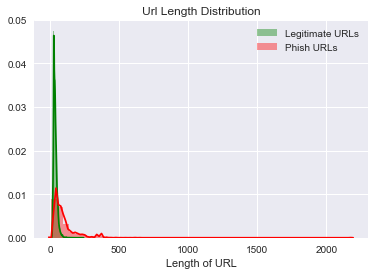

In [19]:
# Data Visualization, Distribution according to length of URL
sns.set(style = 'darkgrid')
sns.distplot(featureSet[featureSet['label'] == 0.0]['len(url)'], color='green', label = 'Legitimate URLs')
sns.distplot(featureSet[featureSet['label'] == 1.0]['len(url)'], color='red', label = 'Phish URLs')
plt.title('Url Length Distribution')
plt.legend(loc = 'upper right')
plt.xlabel('Length of URL')

plt.show()

In [20]:
# Preparing for model training
featureSet = sklearn.utils.shuffle(featureSet)
# axis = 1 means drop by column
X = featureSet.drop(['label'], axis = 1).values # without label
Y = featureSet['label'].values # label
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,1.0,1.0,0.0,94.0,2.0,0.0,0.0,0.0,0.0,1.0,...,15.0,14.0,0.0,18.0,5.0,4.0,99.0,6.0,0.0,0.0
1,1.0,1.0,0.0,62.0,2.0,0.0,0.0,0.0,0.0,1.0,...,36.0,47.0,1.0,36.0,4.0,4.0,86.0,18.0,2.0,4.0
2,1.0,1.0,0.0,21.0,1.0,0.0,0.0,0.0,0.0,0.0,...,12.0,13.0,0.0,16.0,2.0,1.0,27.0,4.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,21.0,3.0,29.0,4.0,0.0,17.0,6.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,16.0,0.0,19.0,2.0,0.0,6.0,7.0,0.0,0.0


In [21]:
pd.DataFrame(Y).head()

,0
0,1.0
1,1.0
2,1.0
3,0.0
4,0.0


In [22]:
from joblib import dump, load

build_model_from_pickel_files = False

if build_model_from_pickel_files == False:
    model = {"Decision Tree" : tree.DecisionTreeClassifier(max_depth = 10),
             "Random Forest" : ensembleLearning.RandomForestClassifier(n_estimators = 50),
             "Adaboost" : ensembleLearning.AdaBoostClassifier(n_estimators = 50),
             "Gradient Boosting" : ensembleLearning.GradientBoostingClassifier(n_estimators = 50),
             "GNB" : GaussianNB(),
             "Logistic Regression" : LogisticRegression(),
             "SVM SVC": svm.SVC(C = 1, cache_size = 200, class_weight = None, coef0 = 0.0, decision_function_shape = 'ovr', degree = 3, gamma = 'auto', kernel = 'linear', max_iter = -1, probability = True, random_state = 1, shrinking = True, tol = 0.001, verbose = False)
    }
else:
    model = {"Decision Tree" : load('DecisionTreeClassifier.joblib'),
             "Random Forest" : load('RandomForestClassifier.joblib'),
             "Adaboost" : load('AdaBoostClassifier.joblib'),
             "Gradient Boosting" : load('GradientBoostingClassifier.joblib'),
             "GNB" : load('GaussianNB.joblib'),
             "Logistic Regression" : load('LogisticRegression.joblib'),
             "SVM SVC": load('SVC.joblib')
    }

Decision Tree : 0.905854141688 
Got 17377 out of 19183
f1 = 0.90
precision = 0.94
recall = 0.86
accuracy = 0.91


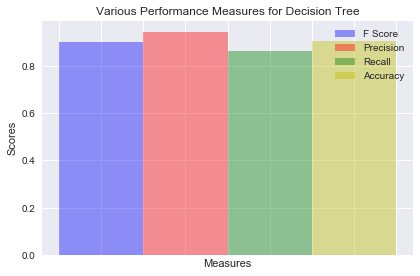

Random Forest : 0.934160454569 
Got 17920 out of 19183
f1 = 0.93
precision = 0.95
recall = 0.92
accuracy = 0.93


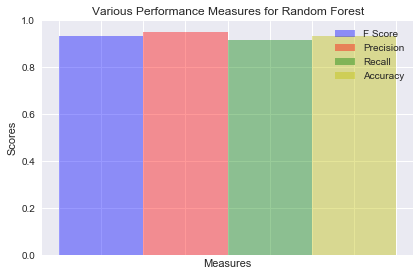

Adaboost : 0.893082416723 
Got 17132 out of 19183
f1 = 0.89
precision = 0.92
recall = 0.86
accuracy = 0.89


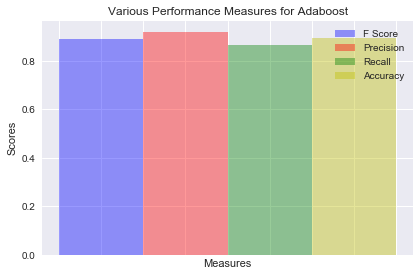

Gradient Boosting : 0.894020747537 
Got 17150 out of 19183
f1 = 0.89
precision = 0.92
recall = 0.86
accuracy = 0.89


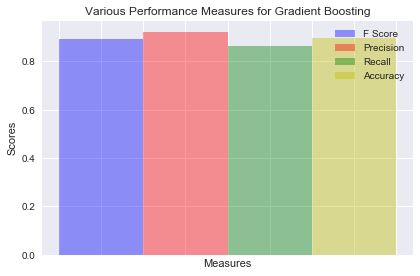

GNB : 0.788510660481 
Got 15126 out of 19183
f1 = 0.75
precision = 0.93
recall = 0.62
accuracy = 0.79


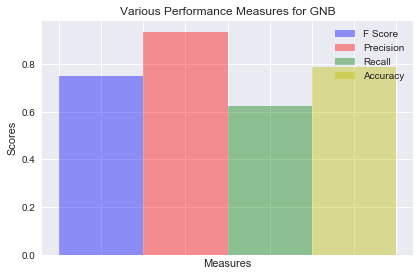

Logistic Regression : 0.866809153938 
Got 16628 out of 19183
f1 = 0.86
precision = 0.90
recall = 0.83
accuracy = 0.87


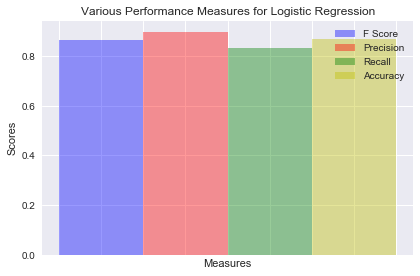

SVM SVC : 0.862378147318 
Got 16543 out of 19183
f1 = 0.86
precision = 0.89
recall = 0.83
accuracy = 0.86


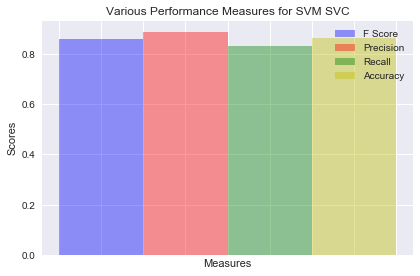

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y , test_size = (1 - cut_ratio))
results = {}

for algo in model:
    clf = model[algo]
    
    if build_model_from_pickel_files == False:
        clf.fit(X_train, Y_train)
        
    score = clf.score(X_test, Y_test)
    print ("%s : %s " %(algo, score))
    results[algo] = score
    
    Y_predict = clf.predict(X_test)
    get_f1_score(Y_test, Y_predict, "Various Performance Measures for %s"%algo)

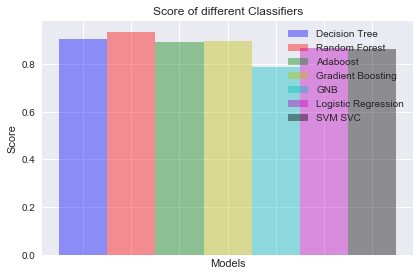

Best Classifier : Random Forest
False positive rate : 4.834312 %
False negative rate : 8.313465 %
             precision    recall  f1-score   support

        0.0       0.92      0.95      0.93      9536
        1.0       0.95      0.92      0.93      9647

avg / total       0.93      0.93      0.93     19183



In [24]:
show_scores_bar(results, model)

winner = max(results, key = results.get)
print("Best Classifier : " + winner)

clf = model[winner]
res = clf.predict(X_test)
con_matrix = confusion_matrix(Y_test, res)

print("False positive rate : %f %%" % ((con_matrix[0][1] / float(sum(con_matrix[0])))*100))
print('False negative rate : %f %%' % ((con_matrix[1][0] / float(sum(con_matrix[1]))*100)))

print(classification_report(Y_test, res))

Got 16510 out of 19183
f1 = 0.87
precision = 0.84
recall = 0.89
accuracy = 0.86


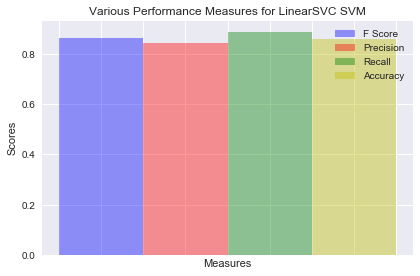

In [49]:
linear_svc = svm.LinearSVC(C = 1).fit(X_train, Y_train)
Y_predict = linear_svc.predict(X_test)
get_f1_score(Y_test, Y_predict, "Various Performance Measures for LinearSVC SVM")

In [51]:
#from joblib import dump, load

#for algo in model:
#    filename = str(model[algo]).split('(')[0] + '.joblib'
#    print('Dumping to ' + filename)
#    dump(clf, filename)
    
#print('Dumping to ' + 'LinearSVC.joblib')
#dump(linear_svc, 'LinearSVC.joblib')

Dumping to DecisionTreeClassifier.joblib
Dumping to RandomForestClassifier.joblib
Dumping to AdaBoostClassifier.joblib
Dumping to GradientBoostingClassifier.joblib
Dumping to GaussianNB.joblib
Dumping to LogisticRegression.joblib
Dumping to SVC.joblib
Dumping to LinearSVC.joblib


['LinearSVC.joblib']

In [52]:
#clf = load('RandomForestClassifier.joblib') 
#res1 = clf.predict(X_test)
#con_matrix1 = confusion_matrix(Y_test, res1)

#print("False positive rate : %f %%" % ((con_matrix1[0][1] / float(sum(con_matrix1[0])))*100))
#print('False negative rate : %f %%' % ((con_matrix1[1][0] / float(sum(con_matrix1[1]))*100)))

#print(classification_report(Y_test, res1))

False positive rate : 4.834312 %
False negative rate : 8.313465 %
             precision    recall  f1-score   support

        0.0       0.92      0.95      0.93      9536
        1.0       0.95      0.92      0.93      9647

avg / total       0.93      0.93      0.93     19183



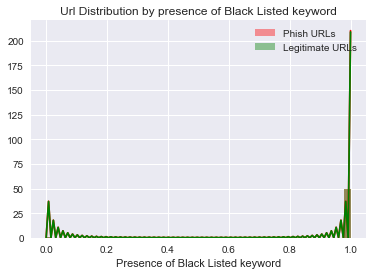

In [28]:
# Data Visualization, Distribution according to length of URL
sns.set(style = 'darkgrid')
sns.distplot(featureSet[featureSet['label'] == 1.0]['Has blacklisted word?'], color='red', label = 'Phish URLs')
sns.distplot(featureSet[featureSet['label'] == 0.0]['Has blacklisted word?'], color='green', label = 'Legitimate URLs')
plt.title('Url Distribution by presence of Black Listed keyword')
plt.legend(loc = 'upper right')
plt.xlabel('Presence of Black Listed keyword')

plt.show()

In [34]:
print("Note:")
print("0.0 means Absence")
print("1.0 means Presence")

print("\nPhish URLs")
print(featureSet.groupby(featureSet[featureSet['label'] == 1.0]['Has blacklisted word?']).size())

print("\nLegitimate URLs")
print(featureSet.groupby(featureSet[featureSet['label'] == 0.0]['Has blacklisted word?']).size())

Note:
0.0 means Absence
1.0 means Presence

Phish URLs
Has blacklisted word?
0.0      281
1.0    47621
dtype: int64

Legitimate URLs
Has blacklisted word?
0.0      581
1.0    47428
dtype: int64


In [36]:
binaryFeatureTitle = \
['Has blacklisted word?',\
'Is hostname unicode?',\
'IP?',\
'http/https?',\
'https?',\
'exe?',\
'short url?',\
'IP Present?',\
'Has Port?']

featureTitle = \
['Length of query',\
'Count Queries',\
'suspicious word count',\
'Token Count',\
'File Name Length',\
'Domain Token Count',\
'Query Variables Count',\
'Maximum Length of Query Variables',\
'Key Value pairs count',\
'Special Char Count',\
'Alphabet Count',\
'Digit Count',\
'len(domain name)',\
'# of @',\
'# of -',\
'# of &',\
'# of delimeter',\

'url # of /',\
'url # of .',\
'len(url)',\

'Subdomain count',\
'Domain alpha Count',\
'Domain numeral Count',\
'SubDomain alpha Count',\
'SubDomain numeral Count',\
'length of subdomain',\
'sub/domain # of /',\
'sub/domain # of .',\
'len(sub/domain)',\

'Path alpha Count',\
'Path numeral Count',\
'directory name length',\
'path # of /',\
'path # of .',\
'len(path)',\
'length longest token path',\
'SubDirectory Token Counts',\
'SubDirectory Delim Count',\

'label']

print("*************************************")        
print("Feature Analysis (Binary Features)")
print("*************************************")        
print("Note:")
print("0.0 means Absence")
print("1.0 means Presence\n\n")
print("-------------------------------------")
print("Phishing URLs statistics")
print("-------------------------------------")
for title in binaryFeatureTitle:
    print(featureSet.groupby(featureSet[featureSet['label'] == 1.0][title]).size())
    print()

print("-------------------------------------")
print("Legitimate URLs statistics")
print("-------------------------------------")
for title in binaryFeatureTitle:
    print(featureSet.groupby(featureSet[featureSet['label'] == 0.0][title]).size())
    print()

*************************************
Feature Analysis (Binary Features)
*************************************
Note:
0.0 means Absence
1.0 means Presence


-------------------------------------
Phishing URLs statistics
-------------------------------------
Has blacklisted word?
0.0      281
1.0    47621
dtype: int64

Is hostname unicode?
1.0    47902
dtype: int64

IP?
0.0    47902
dtype: int64

http/https?
0.0    47902
dtype: int64

https?
0.0    47902
dtype: int64

exe?
0.0    47896
1.0        6
dtype: int64

short url?
0.0    47626
1.0      276
dtype: int64

IP Present?
0.0    47902
dtype: int64

Has Port?
0.0    47902
dtype: int64

-------------------------------------
Legitimate URLs statistics
-------------------------------------
Has blacklisted word?
0.0      581
1.0    47428
dtype: int64

Is hostname unicode?
1.0    48009
dtype: int64

IP?
0.0    48009
dtype: int64

http/https?
0.0    48009
dtype: int64

https?
0.0    48009
dtype: int64

exe?
0.0    47945
1.0       64
dtype: in

In [ ]:
i = 0
for title in binaryFeatureTitle:
    i += 1
    print(str(i) + " " + title)
for title in featureTitle:
    i += 1
    print(str(i) + " " + title)

In [ ]:
# url = dfRequired[['domain']].iloc[from_index:to_index, 0]
# url.head()

In [ ]:
# label = dfRequired[['label']].iloc[from_index:to_index, 0]
# label.head()

In [ ]:
# print("Total Count : " + str(len(label)))

In [ ]:
# features_and_labels = make_feature_vector(from_index, url, label)
# df_features_and_labels = pd.DataFrame(features_and_labels)
# df_features_and_labels.head()

In [ ]:
# len(features_and_labels)

In [ ]:
# features_and_labels = np.array(features_and_labels)
# random.shuffle(features_and_labels)

# cut = int(len(features_and_labels) * cut_ratio)
# XY_train = features_and_labels[:cut]
# XY_test = features_and_labels[cut:]

# df_features_and_labels = pd.DataFrame(features_and_labels)
# df_features_and_labels.head()

In [ ]:
# X_train, Y_train = make_np_array_XY(XY_train)
# X_test, Y_test = make_np_array_XY(XY_test)
# pd.DataFrame(X_train).head()

In [ ]:
# pd.DataFrame(Y_train).head()

In [ ]:
# len(X_train)

In [ ]:
# len(Y_train)

In [ ]:
# SVM SVC Classifier with Linear Kernel
#C = 1.0  # SVM regularization parameter
#svc = svm.SVC(kernel = 'linear', C = C).fit(X_train, Y_train)

In [ ]:
# Predicted Label
#Y_predict = svc.predict(X_test)
#(pd.DataFrame(Y_predict)).head()

In [ ]:
# Actual Label
#(pd.DataFrame(Y_test)).head()

In [ ]:
#print("Prev Winner Score : " + str(clf.score(X_test, Y_test)))
#print("score : " + str(svc.score(X_test, Y_test)))
#get_f1_score(Y_test, Y_predict, "Various Performance Measures for SVM SVC Classifier with Linear Kernel")

In [ ]:
# Hyper Parameter tuning for SVM

# param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf', 'linear']}
# clf = GridSearchCV(svm.SVC(class_weight='balanced'), param_grid)
# clf = clf.fit(X_train, Y_train)
# print("Best estimator found by grid search:")
# print(clf.best_estimator_)
#from sklearn.metrics import make_scorer, roc_auc_score
#auc = make_scorer(roc_auc_score)

#mdl = svm.SVC(probability = True, random_state = 1)

#rand_list = {"C": [0.01, 0.1, 1, 10, 100],
#         'kernel': ['linear']}

#rand_search = RandomizedSearchCV(mdl, param_distributions = rand_list, n_iter = 5, n_jobs = 4, cv = 3, random_state = 2017, scoring = auc) 
#rand_search.fit(X_train, Y_train) 
#rand_search.cv_results_

In [ ]:
#print(rand_search.best_estimator_)